
Data is downloaded from Kaggle "Annotated Corpus for Named Entity Recognition":

https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

## Named Entity Recognition Using BiLSTM
Named Entity Recognition (NER) is the task of identifying and categorizing key information (entities) in text. 
This can be broken down into two sub-tasks: identifying the boundaries of the named entities, and identifying its type.

NER task is a classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

* B - {CHUNK_TYPE} – for the word in the Beginning chunk
* I - {CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk

The IOB tags are further classified into the following classes –

geo = Geographical Entity

org = Organization

per = Person

gpe = Geopolitical Entity

tim = Time indicator

art = Artifact

eve = Event

nat = Natural Phenomenon

In this Notebook bidirectional LSTM is implemented for the NER Task.

## Importing Dependences

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## Loading Dataset 

In [2]:
data = pd.read_csv("/content/ner_dataset.csv", encoding= 'unicode_escape')

In [3]:
data.fillna(method = 'ffill', inplace = True)
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [4]:
data.shape

(1048575, 4)

## Exploratory Data Analysis 

In [5]:
# Data Shape
data.shape

(1048575, 4)

In [6]:
# Number of unique sentences
len(np.unique(data['Sentence #']))

47959

In [7]:
print("Number of unique words in the dataset: {}".format(data.Word.nunique()))
print("Number of unique tags in the dataset: {}".format(data.Tag.nunique()))

Number of unique words in the dataset: 35178
Number of unique tags in the dataset: 17


In [8]:
tags = data.Tag.unique()
tags
#len(tags)

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [9]:
def num_words_tags (tags, data):
    
    """This functions takes the tags we want to count and the datafram 
    and return a dict where the key is the tag and the value is the frequency
    of that tag"""
    
    tags_count = {}
    
    for tag in tags:
        len_tag = len(data[data['Tag'] == tag])
        tags_count[tag] = len_tag
    
    return tags_count

In [10]:
tags_count = num_words_tags(tags, data)
tags_count

{'B-art': 402,
 'B-eve': 308,
 'B-geo': 37644,
 'B-gpe': 15870,
 'B-nat': 201,
 'B-org': 20143,
 'B-per': 16990,
 'B-tim': 20333,
 'I-art': 297,
 'I-eve': 253,
 'I-geo': 7414,
 'I-gpe': 198,
 'I-nat': 51,
 'I-org': 16784,
 'I-per': 17251,
 'I-tim': 6528,
 'O': 887908}

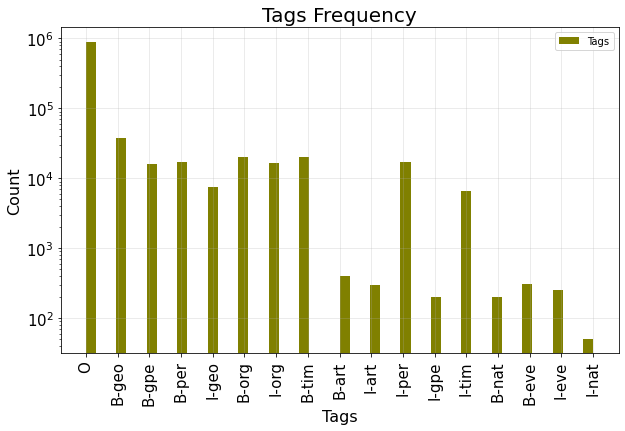

In [11]:
plt.figure(figsize = (10, 6))
plt.hist(data.Tag, log = True, label = 'Tags', color = 'olive', bins = 50)
plt.xlabel('Tags', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title("Tags Frequency", fontsize = 20)
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.show()

## Data Grouping

In [12]:
data1 = data.copy()

In [13]:
data1['Sentence'] = data.groupby(["Sentence #"])['Word'].transform(lambda x:' '.join(x))
#data1['POS'] = data.groupby(["Sentence #"])['POS'].transform(lambda x:' '.join(x))
data1['Tag'] = data.groupby(["Sentence #"])['Tag'].transform(lambda x:' '.join(x))

In [14]:
data1.columns

Index(['Sentence #', 'Word', 'POS', 'Tag', 'Sentence'], dtype='object')

In [15]:
data1 = data1.drop(columns = ['Word','POS'])

In [16]:
data1 = data1.drop_duplicates()
data1.shape

(47959, 3)

In [17]:
data1.head()

,Sentence #,Tag,Sentence
0,Sentence: 1,O O O O O O B-geo O O O O O B-geo O O O O O B-...,Thousands of demonstrators have marched throug...
24,Sentence: 2,O O O O O O O O O O O O O O O O O O B-per O O ...,Families of soldiers killed in the conflict jo...
54,Sentence: 3,O O O O O O O O O O O B-geo I-geo O,They marched from the Houses of Parliament to ...
68,Sentence: 4,O O O O O O O O O O O O O O O,"Police put the number of marchers at 10,000 wh..."
83,Sentence: 5,O O O O O O O O O O O B-geo O O B-org I-org O ...,The protest comes on the eve of the annual con...


## Data Preprocessing

In [18]:
X = list(data1['Sentence'])
Y = list(data1['Tag'])

In [19]:
X[:3]

['Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
 'Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "',
 'They marched from the Houses of Parliament to a rally in Hyde Park .']

In [20]:
Y[:3]

['O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O',
 'O O O O O O O O O O O O O O O O O O B-per O O O O O O O O O O O',
 'O O O O O O O O O O O B-geo I-geo O']

In [21]:
Y1 = []

for sen_tags in Y:
    Y1.append(sen_tags.split())

In [22]:
Y1[:2]

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-gpe',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-per',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']]

### Tokenize the input sentences by mapping each word to a unique identifier, then padding the sentences to the same lenghth.

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
print("Number of examples: {}".format(len(X)))

Number of examples: 47959


Toknizing sentences

In [25]:
# cutoff sentences after 110 words
maxlen = 110

# consider the top 36000 words in the dataset
max_words = 36000

# tokenize each sentence in the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [26]:
word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))
ind2word = dict([(value, key) for (key, value) in word_index.items()])

Found 27953 unique tokens.


In [27]:
word2id = word_index

In [28]:
# dict. that map each identifier to its word
id2word = {}
for key, value in word2id.items():
    id2word[value] = key

Padding sentences

In [29]:
# pad the sequences so that all sequences are of the same size
X_preprocessed = pad_sequences(sequences, maxlen=maxlen, padding='post')

In [30]:
# first example after tokenization and padding. 
X_preprocessed[0]

array([ 260,    3,  997,   13, 1838,  245,  452,    4,  545,    1,  121,
          2,   60,    6,  595,    1,  861,    3,  184,   89,   21,   12,
         54,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [31]:
# 22479 example after tokenization and padding. 
X_preprocessed[22479]

array([ 9811,     2,   640,   454,  2760,   155,   944, 15986,  5319,
        1941,     3,    61,  4900,   155,  4877, 22425,  1941,    17,
       13036, 22426, 22427,     6,   699,   325,   428, 22428,  1941,
       13142, 13143, 22429, 22430,    47,   381,    25,  2859,   907,
       22431,  2166,     4,   155,  1229, 22432,  1941,     2,   754,
         629,     3,    61,  4899,   155,   975, 22433,  1941,    17,
       13036,     6,   699,   454,   428, 22434,  1941, 13142, 13143,
        1033,  1453,    21,     1,   257,  3560,    22,     1,  4417,
           3,     1,  5701,     3,  3783,  2111,  1028,  1243, 22435,
          61,  6936,  2197,  3486,     1,   135,  1185,   257,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

Preprocessing tags by assigning a unique identifier for each one of them: 

- Use the O tag to pad the tag list. 



In [32]:
# dict. that map each tag to its identifier
tags2id = {}
for i, tag in enumerate(tags):
    tags2id[tag] = i

In [33]:
tags2id

{'B-art': 8,
 'B-eve': 14,
 'B-geo': 1,
 'B-gpe': 2,
 'B-nat': 13,
 'B-org': 5,
 'B-per': 3,
 'B-tim': 7,
 'I-art': 9,
 'I-eve': 15,
 'I-geo': 4,
 'I-gpe': 11,
 'I-nat': 16,
 'I-org': 6,
 'I-per': 10,
 'I-tim': 12,
 'O': 0}

In [34]:
# dict. that map each identifier to its tag
id2tag = {}
for key, value in tags2id.items():
    id2tag[value] = key

In [35]:
id2tag

{0: 'O',
 1: 'B-geo',
 2: 'B-gpe',
 3: 'B-per',
 4: 'I-geo',
 5: 'B-org',
 6: 'I-org',
 7: 'B-tim',
 8: 'B-art',
 9: 'I-art',
 10: 'I-per',
 11: 'I-gpe',
 12: 'I-tim',
 13: 'B-nat',
 14: 'B-eve',
 15: 'I-eve',
 16: 'I-nat'}

In [36]:
def preprocess_tags(tags2id, Y1):
    
    Y_preprocessed = []
    maxlen = 110
    # for each target 
    for y in Y1:
        
        # place holder to store the new preprocessed tag list
        Y_place_holder = []
        
        # for each tag in the tag list 
        for tag in y:
            # append the idx of the tag in the place holder list
            Y_place_holder.append(tags2id[tag])
        
        # find the length of the new preprocessed tag list 
        len_new_tag_list = len(Y_place_holder)
        # find the differance in length between the len of tag list and padded sentences
        num_O_to_add = maxlen - len_new_tag_list
        
        # add 'O's to padd the tag lists
        padded_tags = Y_place_holder + ([tags2id['O']] * num_O_to_add)
        Y_preprocessed.append(padded_tags)
        
    return Y_preprocessed

In [37]:
Y_preprocessed = preprocess_tags(tags2id, Y1)

In [38]:
print(Y_preprocessed[0])

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [39]:
print(Y1[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


### Preprocessed Data shuffling and splitting for train, validate and test

In [40]:
print("The Lenght of training examples: {}".format(len(X_preprocessed)))
print("The Lenght of training targets: {}".format(len(Y_preprocessed)))

The Lenght of training examples: 47959
The Lenght of training targets: 47959


In [41]:
X_preprocessed = np.asarray(X_preprocessed)
Y_preprocessed = np.asarray(Y_preprocessed)

In [42]:
# 70% of the datat will be used for training 
training_samples = 0.7
# 15% of the datat will be used for validation 
validation_samples = 0.15
# 15% of the datat will be used for testing 
testing_samples = 0.15

In [43]:
indices = np.arange(len(Y_preprocessed))

In [44]:
np.random.seed(seed=555)
np.random.shuffle(indices)

In [45]:
X_preprocessed = X_preprocessed[indices]
Y_preprocessed = Y_preprocessed[indices]

In [46]:
X_train = X_preprocessed[: int(0.7 * len(X_preprocessed))]
print("Number of training examples: {}".format(len(X_train)))


X_val = X_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
print("Number of validation examples: {}".format(len(X_val)))


X_test = X_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]
print("Number of testing examples: {}".format(len(X_test)))



Y_train = Y_preprocessed[: int(0.7 * len(X_preprocessed))]
Y_val = Y_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
Y_test = Y_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]

print("Total number of examples after shuffling and splitting: {}".format(len(X_train) + len(X_val) + len(X_test)))

Number of training examples: 33571
Number of validation examples: 7194
Number of testing examples: 7194
Total number of examples after shuffling and splitting: 47959


## Model Training and Evaluation

In [50]:
X_train[500]

array([   1, 3558,   48,  243,  117, 7895,   19,   23, 1257,  406,    4,
         24,  156,   18,    1,  110,  654,    6,    4,   36,  182,    3,
          5, 7355,   77,  114,    1,  164,  123,  340, 1253,  634,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [51]:
Y_train[500]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 5, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
id2word[800]

'bodies'

### Load dataset to the model using train_dataset = tf.data.Dataset 


In [53]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [54]:
BATCH_SIZE = 132
SHUFFLE_BUFFER_SIZE = 132

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Build Bi-LSTM model and train

In [57]:
embedding_dim = 300
maxlen = 110
max_words = 36000
num_tags = len(tags)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    tf.keras.layers.SpatialDropout1D(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh', return_sequences=True, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh', return_sequences=True, recurrent_dropout=0.1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_tags, activation='softmax'))
])

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 110, 300)          10800000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 110, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 110, 256)         439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 110, 256)         394240    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 110, 17)          4369      
 ibuted)                                                

In [59]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [60]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10)

Epoch 1/10
255/255 [==============================] - 666s 3s/step - loss: 0.1777 - accuracy: 0.9660 - val_loss: 0.1110 - val_accuracy: 0.9708
Epoch 2/10
255/255 [==============================] - 651s 3s/step - loss: 0.0981 - accuracy: 0.9728 - val_loss: 0.0838 - val_accuracy: 0.9761
Epoch 3/10
255/255 [==============================] - 638s 3s/step - loss: 0.0702 - accuracy: 0.9782 - val_loss: 0.0709 - val_accuracy: 0.9789
Epoch 4/10
255/255 [==============================] - 635s 2s/step - loss: 0.0569 - accuracy: 0.9811 - val_loss: 0.0655 - val_accuracy: 0.9799
Epoch 5/10
255/255 [==============================] - 630s 2s/step - loss: 0.0483 - accuracy: 0.9836 - val_loss: 0.0658 - val_accuracy: 0.9808
Epoch 6/10
255/255 [==============================] - 624s 2s/step - loss: 0.0425 - accuracy: 0.9854 - val_loss: 0.0665 - val_accuracy: 0.9807
Epoch 7/10
255/255 [==============================] - 622s 2s/step - loss: 0.0379 - accuracy: 0.9870 - val_loss: 0.0656 - val_accuracy: 0.9813

### Model Evaluate and Test

In [61]:
model.evaluate(test_dataset)

55/55 [==============================] - 11s 195ms/step - loss: 0.0719 - accuracy: 0.9808


[0.0719389021396637, 0.9808476567268372]

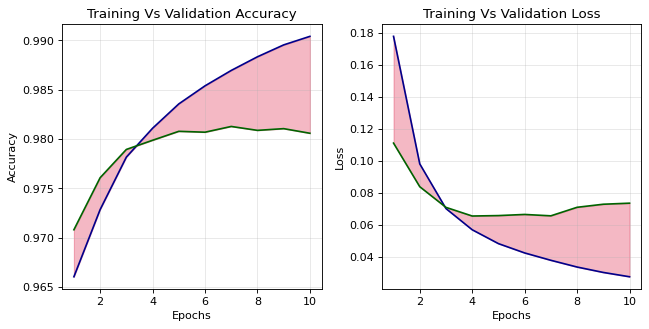

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4), dpi=80)

ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
ax[0].grid(alpha=0.3)
ax[0].title.set_text('Training Vs Validation Accuracy')
ax[0].fill_between(epochs, acc, val_acc, color='crimson', alpha=0.3)
plt.setp(ax[0], xlabel='Epochs')
plt.setp(ax[0], ylabel='Accuracy')


ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
ax[1].grid(alpha=0.3)
ax[1].title.set_text('Training Vs Validation Loss')
ax[1].fill_between(epochs,loss, val_loss, color='crimson', alpha=0.3)
plt.setp(ax[1], xlabel='Epochs')
plt.setp(ax[1], ylabel='Loss')

plt.show()

In [63]:
def make_prediction(model, preprocessed_sentence, id2word, id2tag):
    
    #if preprocessed_sentence.shape() != (1, 110):
    preprocessed_sentence = preprocessed_sentence.reshape((1, 110))
     
    # return preprocessed sentence to its orginal form
    sentence = preprocessed_sentence[preprocessed_sentence > 0]
    word_list = []
    for word in list(sentence):
        word_list.append(id2word[word])
    orginal_sententce = ' '.join(word_list)
    
    len_orginal_sententce = len(word_list)
    
    # make prediction
    prediction = model.predict(preprocessed_sentence)
    prediction = np.argmax(prediction[0], axis=1)
    
    # return the prediction to its orginal form
    prediction = list(prediction)[ : len_orginal_sententce] 
    
    pred_tag_list = []
    for tag_id in prediction:
        pred_tag_list.append(id2tag[tag_id])
    
    return orginal_sententce,  pred_tag_list

In [64]:
orginal_sententce,  pred_tag_list = make_prediction(model=model,
                                                    preprocessed_sentence=X_test[540],
                                                    id2word=id2word,
                                                    id2tag=id2tag)

In [65]:
print(orginal_sententce)

both british prime minister blair and his irish counterpart bertie ahern paid tribute to ms mowlam for her energetic efforts on behalf of peace in northern ireland


In [66]:
print(pred_tag_list)

['O', 'B-gpe', 'B-per', 'I-per', 'I-per', 'O', 'O', 'B-gpe', 'O', 'O', 'B-per', 'I-per', 'O', 'O', 'O', 'B-per', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [67]:
print(Y_test[540])

[ 0  2  3  0  0  0  0  2  0  3 10  0  0  0  3  5  0  0  0  0  0  0  0  0
  0  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [68]:
ls = list(Y_test[540])

In [69]:
for i in ls:
  print(''.join(id2tag[i]), end = ', ')

O, B-gpe, B-per, O, O, O, O, B-gpe, O, B-per, I-per, O, O, O, B-per, B-org, O, O, O, O, O, O, O, O, O, B-geo, I-geo, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, 